This notebook is prepared for simulating Carlemann linearized ode system for a given nonlinear ode and estimate its accuracy.

First, let us define some helper functions

In [ ]:
import numpy as np

def kronecker_power(A: np.ndarray, k: int) -> np.ndarray:
    """
    Compute the k-th Kronecker power of matrix A: A^⊗k = A ⊗ A ⊗ ... ⊗ A (k times)

    Args:
        A: Input matrix
        k: Power (number of Kronecker products)

    Returns:
        A^⊗k
    """
    if k == 0:
        return np.array([[1.0]])  # Scalar 1
    elif k == 1:
        return A
    else:
        result = A
        for _ in range(k - 1):
            result = np.kron(result, A)
        return result


def o_plus_k_operator(A: np.ndarray, k: int) -> np.ndarray:
    """
    The o_plus_k_operator is defined as follows:

    o_plus_k(A) = A ⊗ I^⊗k + Σᵢ₌₁ᵏ⁻¹ (I^⊗i ⊗ A ⊗ I^⊗(k-i)) + I^⊗k ⊗ A

    This operator is fundamental in Carleman linearization theory for computing
    the linearized dynamics of polynomial systems.

    Args:
        A: Input matrix (n × n)
        k: Order parameter

    Returns:
        The o_plus_k operator applied to A

    Mathematical interpretation:
    - First term: A ⊗ I^⊗k acts on the first component
    - Middle terms: A acts on the (i+1)-th component for i = 1, ..., k-1
    - Last term: I^⊗k ⊗ A acts on the last component
    """
    n = A.shape[0]
    # if A.shape[1] != n:
    #     raise ValueError("Matrix A must be square")

    if k == 0:
        return A

    # Identity matrix of same size as A
    I = np.eye(n)

    # Compute I^⊗k (k-th Kronecker power of identity)
    I_k = kronecker_power(I, k)

    # Initialize result with first term: A ⊗ I^⊗k
    result = np.kron(A, I_k)

    # Add middle terms: Σᵢ₌₁ᵏ⁻¹ (I^⊗i ⊗ A ⊗ I^⊗(k-i))
    for i in range(1, k):
        I_i = kronecker_power(I, i)        # I^⊗i
        I_k_minus_i = kronecker_power(I, k - i)  # I^⊗(k-i)

        # Compute I^⊗i ⊗ A ⊗ I^⊗(k-i)
        term = np.kron(np.kron(I_i, A), I_k_minus_i)
        result += term

    # Add last term: I^⊗k ⊗ A
    result += np.kron(I_k, A)

    return result

def threshold_clean_eigenvalues(eigenvalues, tol=1e-12):
    cleaned = []
    for val in eigenvalues:
        real = 0.0 if abs(val.real) < tol else val.real
        imag = 0.0 if abs(val.imag) < tol else val.imag
        cleaned.append(complex(real, imag))
    return np.array(cleaned)

def is_normal(A, tol=1e-10):
    return np.allclose(A @ A.conj().T, A.conj().T @ A, atol=tol)


In [ ]:
def test_o_plus_k_operator():
    """Test the o_plus_k_operator implementation with known cases."""
    print("Testing o_plus_k_operator...")

    # Test case 1: Simple 2x2 matrix, k=1
    A = np.array([[1, 2], [3, 4]])
    result_k1 = o_plus_k_operator(A, 1)
    I = np.eye(2)
    I_2 = np.kron(I,I)
    expected_k1 = np.kron(I,A) + np.kron(A,I)  # For k=1: A ⊗ I + I ⊗ A where I is 1x1
    print("Input Matrix:")
    print(A)
    print("Computed Result:", result_k1)
    print("Expected Result:", expected_k1)
    print(f"Test 1 (k=1): {'PASS' if np.allclose(result_k1, expected_k1) else 'FAIL'}")

    # Test case 2: k=0 should return A
    result_k0 = o_plus_k_operator(A, 0)
    print(f"Test 2 (k=0): {'PASS' if np.allclose(result_k0, A) else 'FAIL'}")

    #I \otimes A \otimes I + I\otimes I \otimes A + A \otimes I \otimes I
    # Test case 3: Verify Matrices
    result_k2 = o_plus_k_operator(A, 2)
    expected_k2 = np.kron(I,result_k1) + np.kron(A,I_2)
    print(f"Test 1 (k=1): {'PASS' if np.allclose(result_k2, expected_k2) else 'FAIL'}")

    # Test case 4: Manual verification for k=2, 1x1 matrix
    A_1x1 = np.array([[2]])
    result_1x1_k2 = o_plus_k_operator(A_1x1, 2)
    # For 1x1 matrix with k=2: A⊗I⊗I + I⊗A⊗I + I⊗I⊗A = 3*A (since I=1)
    expected_1x1_k2 = 3 * A_1x1
    print(f"Test 4 (1x1, k=2): {'PASS' if np.allclose(result_1x1_k2, expected_1x1_k2) else 'FAIL'}")


In [ ]:
test_o_plus_k_operator()

Testing o_plus_k_operator...
Input Matrix:
[[1 2]
 [3 4]]
Computed Result: [[2. 2. 2. 0.]
 [3. 5. 0. 2.]
 [3. 0. 5. 2.]
 [0. 3. 3. 8.]]
Expected Result: [[2. 2. 2. 0.]
 [3. 5. 0. 2.]
 [3. 0. 5. 2.]
 [0. 3. 3. 8.]]
Test 1 (k=1): PASS
Test 2 (k=0): PASS
Test 1 (k=1): PASS
Test 4 (1x1, k=2): PASS


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement, product
import time

class CarlemanLinearization:
    def __init__(self, A1, A2, n_states, truncation_order):
        """
        Initialize Carleman linearization for system: dx/dt = A1*x + A2*(x⊗x)

        Parameters:
        A1: Linear coefficient matrix (n×n)
        A2: Quadratic coefficient matrix (n×n²)
        n_states: Number of original states
        truncation_order: Maximum order for Kronecker products
        """
        self.A1 = np.array(A1)
        self.A2 = np.array(A2)
        self.n = n_states
        self.k = truncation_order

        # Validate input dimensions
        assert self.A1.shape == (self.n, self.n), f"A1 must be {self.n}×{self.n}"
        assert self.A2.shape == (self.n, self.n**2), f"A2 must be {self.n}×{self.n**2}"

        # Build the Carleman matrix Q
        self.Q = self._build_carleman_matrix_bidiagonal()

    def _kronecker_indices(self, order):
        """Generate indices for Kronecker products of given order"""
        # For Kronecker products, we need all combinations, not just combinations with replacement
        # x⊗x for 2D system should be [x1⊗x1, x1⊗x2, x2⊗x1, x2⊗x2] = 4 elements
        from itertools import product
        return list(product(range(self.n), repeat=order))

    def _kronecker_product_recursive(self, x, order):
        """Compute x^⊗order efficiently"""
        if order == 1:
            return x
        elif order == 2:
            return np.kron(x, x)
        else:
            return np.kron(x, self._kronecker_product_recursive(x, order-1))

    def _build_carleman_matrix_bidiagonal(self) -> np.ndarray:
        """
        Build the Carleman matrix with the correct bidiagonal block structure.

        The matrix has the form:
        C = [[A₁,           A₂,           0,            0,     ...]
            [0,            A₁⊕₁A₁,      A₂⊕₁A₂,      0,     ...]
            [0,            0,            A₁⊕₂A₁,      A₂⊕₂A₂, ...]
            [0,            0,            0,            A₁⊕₃A₁, ...]
            [...]]

        Args:
            A_1: First matrix operator
            A_2: Second matrix operator
            truncation_order: Order at which to truncate the Carleman matrix

        Returns:
            Carleman matrix of size (carleman_dim × carleman_dim)
        """
        # Get dimension n from A_1 (assuming A_1 is n×n)
        n = self.A1.shape[0]
        truncation_order = self.k

        # Compute Carleman dimension: n + n² + ... + n^k
        carleman_dim = sum(n**i for i in range(1, truncation_order + 1))

        # Compute order start indices and dimensions
        order_dimensions = [n**i for i in range(1, truncation_order + 1)]
        order_start_indices = [0]
        for i in range(1, truncation_order):
            order_start_indices.append(order_start_indices[-1] + order_dimensions[i-1])

        C = np.zeros((carleman_dim, carleman_dim))

        # Fill the bidiagonal blocks
        for k in range(truncation_order):
            row_start = order_start_indices[k]
            row_end = row_start + order_dimensions[k]

            # Diagonal block: A₁⊕ₖA₁ (for k=0, this is just A₁)
            col_start = row_start
            col_end = row_end

            if k == 0:
                # First diagonal block is just A₁
                C[row_start:row_end, col_start:col_end] = self.A1
            else:
                # Higher order diagonal blocks: A₁⊕ₖA₁
                A1_oplus_k = o_plus_k_operator(self.A1, k)
                C[row_start:row_end, col_start:col_end] = A1_oplus_k

            # Super-diagonal block: A₂⊕ₖA₂ (if not the last block)
            if k < truncation_order - 1:
                col_start = order_start_indices[k + 1]
                col_end = col_start + order_dimensions[k + 1]

                if k == 0:
                    # First super-diagonal block is just A₂
                    C[row_start:row_end, col_start:col_end] = self.A2
                else:
                    # Higher order super-diagonal blocks: A₂⊕ₖA₂
                    A2_oplus_k = o_plus_k_operator(self.A2, k)
                    C[row_start:row_end, col_start:col_end] = A2_oplus_k

        return C

    def _construct_carleman_matrix(self):
        """Construct the Carleman linearization matrix Q"""
        # Calculate dimensions for each order
        dims = []
        total_dim = 0
        for i in range(1, self.k + 1):
            dim_i = self.n ** i  # Correct dimension for Kronecker products
            dims.append(dim_i)
            total_dim += dim_i

        print(f"Carleman matrix dimensions: {total_dim}×{total_dim}")
        print(f"Dimension breakdown: {dims}")
        Q = np.zeros((total_dim, total_dim))

        # The Carleman matrix has a specific block structure:
        # Q = [Q11  Q12  Q13  ...]
        #     [Q21  Q22  Q23  ...]
        #     [Q31  Q32  Q33  ...]
        #     [...  ...  ...  ...]

        # Fill Q block by block
        row_start = 0
        for i in range(1, self.k + 1):
            row_end = row_start + dims[i-1]
            col_start = 0

            for j in range(1, self.k + 1):
                col_end = col_start + dims[j-1]

                # Determine what goes in block Q[i,j]
                if i == 1 and j == 1:
                    # Q_{1,1} = A1: how x evolves from linear terms
                    Q[row_start:row_end, col_start:col_end] = self.A1

                elif i == 1 and j == 2:
                    # Q_{1,2} = A2: how x evolves from quadratic terms x⊗x
                    Q[row_start:row_end, col_start:col_end] = self.A2

                elif i == 2 and j == 1:
                    # Q_{2,1}: how x⊗x evolves from linear x terms
                    # d/dt(x⊗x) = dx/dt ⊗ x + x ⊗ dx/dt = (A1⊗I + I⊗A1)(x⊗x) when dx/dt = A1*x
                    # But we want the coupling from x to x⊗x, which is more complex
                    I = np.eye(self.n)
                    Q[row_start:row_end, col_start:col_end] = self._compute_x_to_xx_coupling()

                elif i == 2 and j == 2:
                    # Q_{2,2}: how x⊗x evolves from x⊗x terms
                    I = np.eye(self.n)
                    Q[row_start:row_end, col_start:col_end] = np.kron(self.A1, I) + np.kron(I, self.A1)

                # For higher order blocks, use simplified structure
                elif i > 2 and j == 1:
                    # Higher order coupling from x
                    Q[row_start:row_end, col_start:col_end] = self._compute_higher_order_coupling(i, 1)

                elif i > 2 and j == 2:
                    # Higher order coupling from x⊗x
                    Q[row_start:row_end, col_start:col_end] = self._compute_higher_order_coupling(i, 2)

                elif i > 2 and j > 2 and i == j:
                    # Diagonal blocks for higher orders (simplified)
                    Q[row_start:row_end, col_start:col_end] = self._compute_diagonal_block(i)

                col_start = col_end
            row_start = row_end

        return Q



    def construct_augmented_state(self, x):
        """Construct augmented state vector y = [x, x⊗x, x⊗x⊗x, ...]"""
        y = x.copy()
        for order in range(2, self.k + 1):
            x_kron = self._kronecker_product_recursive(x, order)
            y = np.concatenate([y, x_kron])
        return y

    def extract_original_state(self, y):
        """Extract original state x from augmented state y"""
        return y[:self.n]

    def carleman_dynamics(self, t, y):
        """Carleman linearized dynamics: dy/dt = Q*y"""
        return self.Q @ y

    def original_dynamics(self, t, x):
        """Original nonlinear dynamics: dx/dt = A1*x + A2*(x⊗x)"""
        x_kron_2 = np.kron(x, x)
        return self.A1 @ x + self.A2 @ x_kron_2

def simulate_and_compare(A1, A2, x0, t_span, t_eval, truncation_order=3):
    """
    Simulate both original and Carleman linearized systems and compare results
    """
    n_states = len(x0)

    # Create Carleman linearization
    carleman = CarlemanLinearization(A1, A2, n_states, truncation_order)
    print("Eigenvalues of the Carlemann Matrix:")
    print(threshold_clean_eigenvalues(np.linalg.eigvals(carleman.Q)))
    # Initial conditions
    y0 = carleman.construct_augmented_state(x0)
    if is_normal(carleman.Q):
      print("The Carleman matrix is normal")
    else:
      print("The Carleman matrix is not normal")
    print(f"Original system dimension: {n_states}")
    print(f"Carleman system dimension: {len(y0)}")

    # Solve original system
    print("Solving original nonlinear system...")
    sol_original = solve_ivp(carleman.original_dynamics, t_span, x0,
                           t_eval=t_eval, method='Radau', rtol=1e-10, atol=1e-12)
    #sol_original = solve_ivp(carleman.original_dynamics, t_span, x0, method='DOP853', rtol=1e-10, atol=1e-12)

    # Solve Carleman linearized system
    print("Solving Carleman linearized system...")
    sol_carleman = solve_ivp(carleman.carleman_dynamics, t_span, y0,
                           t_eval=t_eval, method='Radau', rtol=1e-10, atol=1e-12)

    # Extract original states from Carleman solution
    x_carleman = np.array([carleman.extract_original_state(y)
                          for y in sol_carleman.y.T]).T

    print("Comparison between original and Carleman:")
    print("Original Solution:")
    print(sol_original)
    print("Carleman Solution:")
    print(x_carleman)

    return sol_original, x_carleman, carleman

def plot_results(t_eval, x_original, x_carleman, truncation_order):
    """Plot comparison between original and Carleman approximation"""
    n_states = x_original.shape[0]

    fig, axes = plt.subplots(2, n_states, figsize=(4*n_states, 8))
    if n_states == 1:
        axes = axes.reshape(2, 1)

    # Plot state trajectories
    for i in range(n_states):
        axes[0, i].plot(t_eval, x_original[i, :], 'b-', label='Original', linewidth=2)
        axes[0, i].plot(t_eval, x_carleman[i, :], 'r--', label=f'Carleman (k={truncation_order})', linewidth=2)
        axes[0, i].set_xlabel('Time')
        axes[0, i].set_ylabel(f'x_{i+1}(t)')
        axes[0, i].set_title(f'State {i+1} Comparison')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

    # Plot errors
    errors = np.abs(x_original - x_carleman)
    for i in range(n_states):
        axes[1, i].semilogy(t_eval, errors[i, :], 'g-', linewidth=2)
        axes[1, i].set_xlabel('Time')
        axes[1, i].set_ylabel(f'|Error| in x_{i+1}')
        axes[1, i].set_title(f'Absolute Error for State {i+1}')
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print error statistics
    print(f"\nError Statistics (Truncation order k={truncation_order}):")
    print("-" * 50)
    for i in range(n_states):
        max_error = np.max(errors[i, :])
        mean_error = np.mean(errors[i, :])
        final_error = errors[i, -1]
        print(f"State {i+1}: Max error = {max_error:.2e}, Mean error = {mean_error:.2e}, Final error = {final_error:.2e}")



Example 1: 2D Nonlinear System
Eigenvalues of the Carlemann Matrix:
[0. +8.j 0. -8.j 0.+16.j 0.-16.j 0. +0.j 0. +0.j 0.+24.j 0.-24.j 0. +8.j
 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0.+32.j 0.-32.j 0. +0.j 0.+16.j
 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j]
The Carleman matrix is not normal
Original system dimension: 2
Carleman system dimension: 30
Solving original nonlinear system...
Solving Carleman linearized system...
Comparison between original and Carleman:
Original Solution:
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.513e-01 ...  4.975e+01  5.000e+01]
        y: [[ 3.330e-01  1.587e-01 ...  9.598e-02 -4.572e-01]
            [ 3.330e-01 -4.442e-01 ... -4.619e-01  1.092e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 273533
     njev: 2
      nlu: 6
Carleman Solution:
[[ 0.333       0.15874264 -0.4678403   0.23873599  0

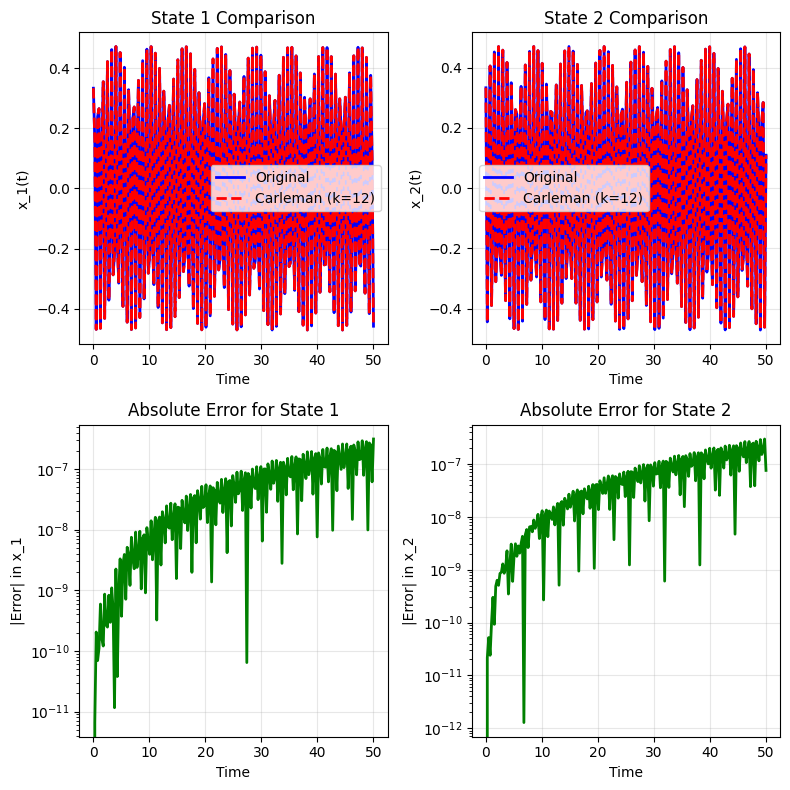


Error Statistics (Truncation order k=12):
--------------------------------------------------
State 1: Max error = 3.13e-07, Mean error = 6.64e-08, Final error = 3.13e-07
State 2: Max error = 2.97e-07, Mean error = 6.71e-08, Final error = 7.55e-08

Example 2: Truncation Order Comparison

Testing truncation order k=2
Eigenvalues of the Carlemann Matrix:
[0. +8.j 0. -8.j 0.+16.j 0.-16.j 0. +0.j 0. +0.j]
The Carleman matrix is not normal
Original system dimension: 2
Carleman system dimension: 6
Solving original nonlinear system...
Solving Carleman linearized system...
Comparison between original and Carleman:
Original Solution:
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.513e-01 ...  4.975e+01  5.000e+01]
        y: [[ 3.330e-01  1.587e-01 ...  9.598e-02 -4.572e-01]
            [ 3.330e-01 -4.442e-01 ... -4.619e-01  1.092e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 273533
     n

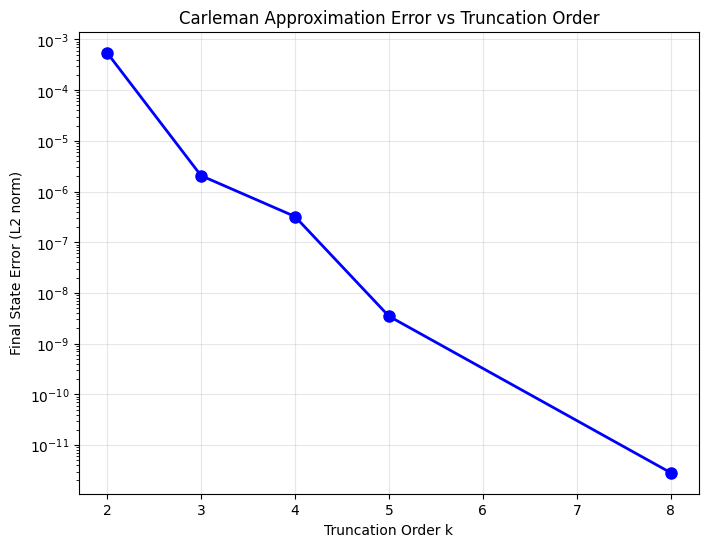


Carleman matrix sparsity: 14.7% non-zero


In [ ]:
# Example usage
if __name__ == "__main__":
    # Example 1: 2D system with Van der Pol-like dynamics
    print("Example 1: 2D Nonlinear System")
    print("=" * 40)

    # System: dx1/dt = x2 + 0.1*x1*x2
    #         dx2/dt = -x1 + 0.05*(x1^2 - x2^2)
    A1 = np.array([[-0.000, 8],
                   [-8, -0.000]])

    # A2 matrix for quadratic terms [x1*x1, x1*x2, x2*x1, x2*x2]
    A2 = np.array([[0.0, 0.1, 0, 0],
                   [0.00, 0.1, 0, 0.00]])

    x0 = np.array([0.333, 0.333])
    t_span = (0, 50)
    t_eval = np.linspace(0, 50, 200)

    sol_orig, x_carl, carleman_sys = simulate_and_compare(
        A1, A2, x0, t_span, t_eval, truncation_order=4)

    plot_results(t_eval, sol_orig.y, x_carl, 12)

    # Example 2: Test different truncation orders
    print("\nExample 2: Truncation Order Comparison")
    print("=" * 40)

    truncation_orders = [2, 3, 4,5,8]
    final_errors = []

    for k in truncation_orders:
        print(f"\nTesting truncation order k={k}")
        sol_orig, x_carl, _ = simulate_and_compare(
            A1, A2, x0, t_span, t_eval, truncation_order=k)
        print("Original Solution:")
        print(sol_orig.y[:, -1])
        print("Carleman Solution:")
        print(x_carl[:, -1])
        error = np.linalg.norm(sol_orig.y[:, -1] - x_carl[:, -1])
        final_errors.append(error)
        print(f"Final state error (L2 norm): {error}")

    # Plot truncation order comparison
    plt.figure(figsize=(8, 6))
    plt.semilogy(truncation_orders, final_errors, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Truncation Order k')
    plt.ylabel('Final State Error (L2 norm)')
    plt.title('Carleman Approximation Error vs Truncation Order')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\nCarleman matrix sparsity: {np.count_nonzero(carleman_sys.Q) / carleman_sys.Q.size * 100:.1f}% non-zero")

In [ ]:
import numpy as np

B = np.array([[-0.000, 8],
              [-8, -0.000]])

B_dagger = B.T.conj()

H1 = np.block([
    [np.zeros((2, 2)), B],
    [-B_dagger,         np.zeros((2, 2))]
])
H2 = np.zeros((4,16))
H2[0,0] = 0.3
H2[0,1] = 0.2
A1 = np.array([[-0.000, 0,0,8],
              [-0.000, 0,0,8],
              [-0.000, 0,0,8],
            [-0.000, 0,0,8]])

# A2 matrix for quadratic terms [x1*x1, x1*x2, x2*x1, x2*x2]
A2 = np.array([[0.0, 0.1, 0, 0],
            [0.00, 0.1, 0, 0.00]])

In [ ]:
print(H1)
print(H2)
print("Eigenvalues of H1:", np.linalg.eigvals(H1))

[[ 0.  0. -0.  8.]
 [ 0.  0. -8. -0.]
 [ 0.  8.  0.  0.]
 [-8.  0.  0.  0.]]
[[0.3 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
Eigenvalues of H1: [0.+8.j 0.-8.j 0.+8.j 0.-8.j]


Eigenvalues of the Carlemann Matrix:
[0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +0.j 0. +0.j 0. +0.j 0.+16.j 0.-16.j
 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0.+24.j 0.-24.j 0.+24.j 0.-24.j 0.+24.j 0.-24.j 0.+24.j
 0.-24.j 0.+24.j 0.-24.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j
 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j
 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j
 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0.+24.j 0.-24.j 0.+24.j
 0.-24.j 0.+24.j 0.-24.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j
 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j 0. -8.j 0. +8.j
 0. -8.j 0. +8.j 0. -8.j 0.+32.j 0.-32.j 0.+32.j 0.-32.j 0.+32.j 0.-32.j
 0.+32.j 0.-32.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j
 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j
 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j
 0.-16.j 0.+32

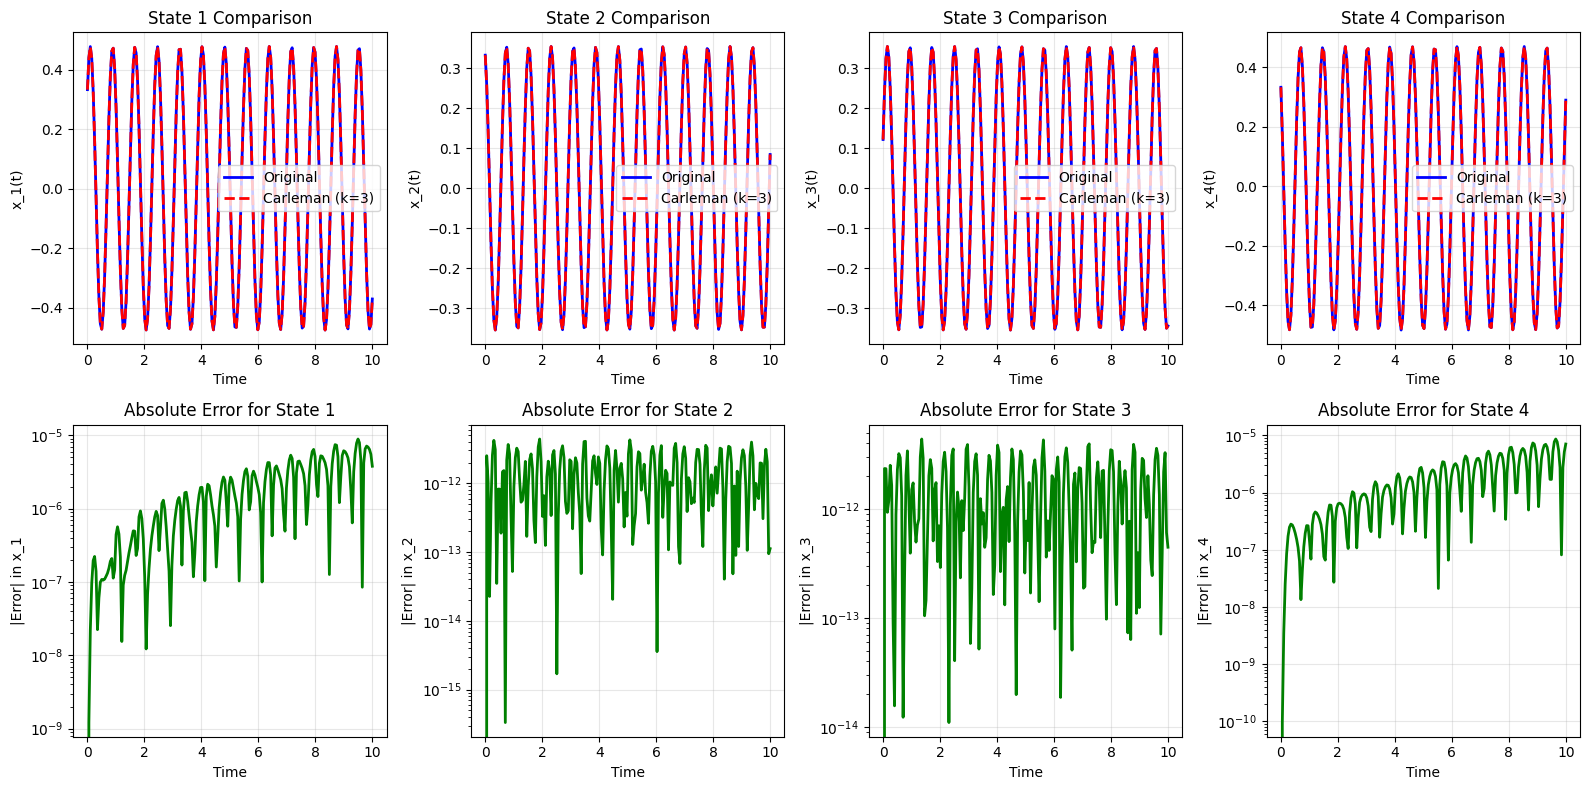


Error Statistics (Truncation order k=3):
--------------------------------------------------
State 1: Max error = 8.89e-06, Mean error = 2.02e-06, Final error = 3.78e-06
State 2: Max error = 4.40e-12, Mean error = 1.50e-12, Final error = 1.12e-13
State 3: Max error = 4.39e-12, Mean error = 1.51e-12, Final error = 4.46e-13
State 4: Max error = 8.67e-06, Mean error = 1.96e-06, Final error = 7.08e-06


In [ ]:
x0 = np.array([0.333, 0.333,0.122,0.333])
t_span = (0, 10)
t_eval = np.linspace(0, 10, 200)
sol_orig, x_carl, carleman_sys = simulate_and_compare(H1, H2, x0, t_span, t_eval, truncation_order=4)
plot_results(t_eval, sol_orig.y, x_carl, 3)

Truncation Order Sweep


Testing truncation order k=2
Eigenvalues of the Carlemann Matrix:
[0. +8.j 0. -8.j 0. +8.j 0. -8.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j
 0.-16.j 0.+16.j 0.-16.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j]
The Carleman matrix is not normal
Original system dimension: 4
Carleman system dimension: 20
Solving original nonlinear system...
Solving Carleman linearized system...
Comparison between original and Carleman:
Original Solution:
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.025e-02 ...  9.950e+00  1.000e+01]
        y: [[ 3.330e-01  4.402e-01 ... -4.575e-01 -3.711e-01]
            [ 3.330e-01  2.587e-01 ... -5.701e-02  8.450e-02]
            [ 1.220e-01  2.426e-01 ... -3.500e-01 -3.444e-01]
            [ 3.330e-01  1.755e-01 ...  1.210e-01  2.898e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 54212
     njev: 2
      nlu: 4
Carleman Solution:
[[ 0.333   

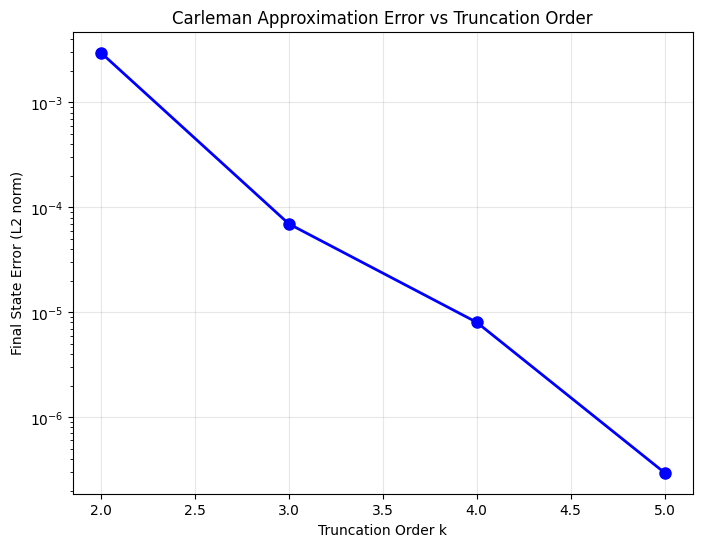

In [ ]:
truncation_orders = [2, 3, 4,5]
final_errors = []
for k in truncation_orders:
    print(f"\nTesting truncation order k={k}")
    sol_orig, x_carl, _ = simulate_and_compare(
            H1, H2, x0, t_span, t_eval, truncation_order=k)
    print("Original Solution:")
    print(sol_orig.y[:, -1])
    print("Carleman Solution:")
    print(x_carl[:, -1])
    error = np.linalg.norm(sol_orig.y[:, -1] - x_carl[:, -1])
    final_errors.append(error)
    print(f"Final state error (L2 norm): {error}")

# Plot truncation order comparison
plt.figure(figsize=(8, 6))
plt.semilogy(truncation_orders, final_errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Truncation Order k')
plt.ylabel('Final State Error (L2 norm)')
plt.title('Carleman Approximation Error vs Truncation Order')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import numpy as np

B = np.array([[-0.000, 8],
              [-8, -0.000]])

B_dagger = B.T.conj()

H1 = np.block([
    [np.zeros((2, 2)), B],
    [-B_dagger,         np.zeros((2, 2))]
])
H2 = np.zeros((4,16))
H2[0,0] = 0.3
H2[0,1] = 0.2
H2[0,2] = 0.3
H2[0,3] = 0.2
H2[1,0] = 0.3
H2[1,1] = 0.2
H2[1,2] = 0.3
H2[1,3] = 0.2
A1 = np.array([[-0.000, 0,0,8],
              [-0.000, 0,0,8],
              [-0.000, 0,0,8],
            [-0.000, 0,0,8]])

# A2 matrix for quadratic terms [x1*x1, x1*x2, x2*x1, x2*x2]
A2 = np.array([[0.0, 0.1, 0, 0],
            [0.00, 0.1, 0, 0.00]])

In [ ]:
print(H1)
print(H2)


[[ 0.  0. -0.  8.]
 [ 0.  0. -8. -0.]
 [ 0.  8.  0.  0.]
 [-8.  0.  0.  0.]]
[[0.3 0.2 0.3 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.3 0.2 0.3 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]



Testing truncation order k=2
Eigenvalues of the Carlemann Matrix:
[0. +8.j 0. -8.j 0. +8.j 0. -8.j 0.+16.j 0.-16.j 0.+16.j 0.-16.j 0.+16.j
 0.-16.j 0.+16.j 0.-16.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j]
The Carleman matrix is not normal
Original system dimension: 4
Carleman system dimension: 20
Solving original nonlinear system...
Solving Carleman linearized system...
Comparison between original and Carleman:
Original Solution:
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.025e-02 ...  9.950e+00  1.000e+01]
        y: [[ 3.330e-01  4.423e-01 ... -4.625e-01 -3.766e-01]
            [ 3.330e-01  2.642e-01 ... -6.600e-02  7.558e-02]
            [ 1.220e-01  2.436e-01 ... -3.384e-01 -3.363e-01]
            [ 3.330e-01  1.751e-01 ...  1.152e-01  2.861e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 58589
     njev: 2
      nlu: 170
Carleman Solution:
[[ 3.3300

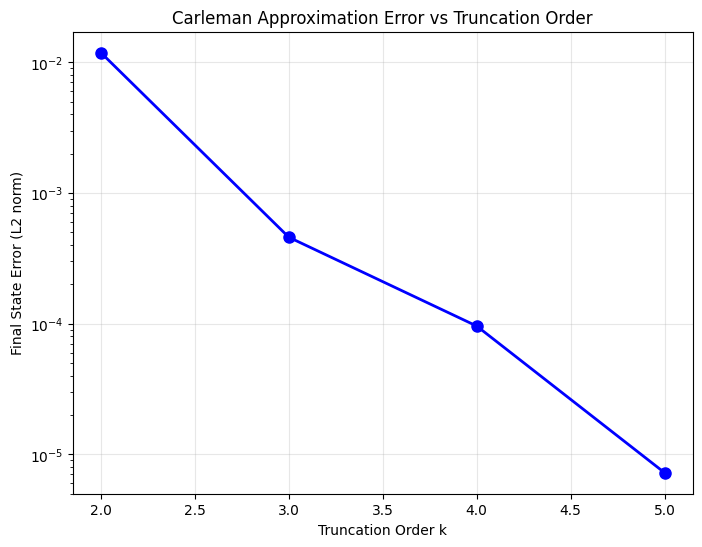

In [ ]:
truncation_orders = [2, 3, 4,5]
final_errors = []
for k in truncation_orders:
    print(f"\nTesting truncation order k={k}")
    sol_orig, x_carl, _ = simulate_and_compare(
            H1, H2, x0, t_span, t_eval, truncation_order=k)
    print("Original Solution:")
    print(sol_orig.y[:, -1])
    print("Carleman Solution:")
    print(x_carl[:, -1])
    error = np.linalg.norm(sol_orig.y[:, -1] - x_carl[:, -1])
    final_errors.append(error)
    print(f"Final state error (L2 norm): {error}")

# Plot truncation order comparison
plt.figure(figsize=(8, 6))
plt.semilogy(truncation_orders, final_errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Truncation Order k')
plt.ylabel('Final State Error (L2 norm)')
plt.title('Carleman Approximation Error vs Truncation Order')
plt.grid(True, alpha=0.3)
plt.show()